In [ ]:
#
# Title: Final U-Net Training Pipeline for Brain Segmentation
#
# Description: This notebook implements a complete, state-of-the-art training pipeline.
# It uses a pre-trained ResNet50 encoder, a custom data generator with heavy
# Albumentations, a robust Focal-Dice loss, and a two-stage fine-tuning strategy.
#

In [ ]:
# Albumentations is used for powerful data augmentation.
!pip install -U albumentations

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import math
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split

In [ ]:
# --- Define all key parameters and paths here for easy modification ---

# Image dimensions
IMG_HEIGHT = 256
IMG_WIDTH = 256

# Paths to your dataset in Google Drive
IMAGE_PATH = '/content/drive/MyDrive/150_AD_CN_11112025/images/'
MASK_PATH = '/content/drive/MyDrive/150_AD_CN_11112025/masks/'
METADATA_PATH = '/content/drive/MyDrive/150_AD_CN_11112025/metadata.csv'

# Training Hyperparameters
BATCH_SIZE = 16 # Keep at 16. If you get memory errors, reduce to 8.

In [ ]:
# --- Data Loading and Preprocessing Pipeline ---
# This function loads data based on your clean metadata.csv file.

def load_data_from_csv(image_dir, mask_dir, metadata_path):
    try:
        metadata = pd.read_csv(metadata_path)
    except FileNotFoundError:
        print(f"--- ERROR: metadata.csv not found at '{metadata_path}'!")
        return None, None

    image_dataset = []
    mask_dataset = []

    for index, row in tqdm(metadata.iterrows(), total=len(metadata), desc="Loading Data"):
        image_path = os.path.join(image_dir, row['image_id'])
        mask_path = os.path.join(mask_dir, row['mask_id'])

        if not os.path.exists(image_path) or not os.path.exists(mask_path):
            continue

        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if image is not None and mask is not None:
            image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
            mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
            image_dataset.append(image)
            mask_dataset.append(mask)

    if not image_dataset:
        print("\n--- ERROR: No image-mask pairs were loaded! ---")
        return None, None

    # Normalize and add channel dimension
    # Ensure float32 from the start to avoid type issues with Albumentations/OpenCV
    image_array = (np.array(image_dataset) / 255.0).astype(np.float32)
    mask_array = (np.array(mask_dataset) / 255.0).astype(np.float32)
    mask_array[mask_array > 0.5] = 1.0 # Ensure mask values are 0.0 or 1.0
    mask_array[mask_array <= 0.5] = 0.0

    image_array = np.expand_dims(image_array, axis=-1)
    mask_array = np.expand_dims(mask_array, axis=-1)

    return image_array, mask_array

# --- Load the data ---
X, y = load_data_from_csv(IMAGE_PATH, MASK_PATH, METADATA_PATH)

if X is not None:
    print("\n--- Data Loading and Preprocessing Complete ---")
    print(f"Total images loaded: {len(X)}")
    print(f"Images shape: {X.shape}")
    print(f"Masks shape: {y.shape}")

    # --- Split the data ---
    # Using an 80/20 split for a more stable validation set
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Training images: {len(X_train)}")
    print(f"Validation images: {len(X_val)}")

Loading Data: 100%|██████████| 150/150 [00:01<00:00, 93.53it/s]



--- Data Loading and Preprocessing Complete ---
Total images loaded: 150
Images shape: (150, 256, 256, 1)
Masks shape: (150, 256, 256, 1)
Training images: 120
Validation images: 30


In [ ]:
# --- FINAL, CORRECTED Data Augmentation and Custom Generator Cell ---
import albumentations as A
from tensorflow.keras.utils import Sequence
import cv2
import numpy as np
import math

# --- 1. Define the Augmentation Pipeline with MODERN Syntax ---
# This version uses the updated arguments for the latest Albumentations library.
aug_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),

    # The 'Affine' transform now combines shift, scale, and rotate.
    # Using 'fill_value_image' for border_mode=cv2.BORDER_CONSTANT (modern syntax)
    A.Affine(
        scale=(0.9, 1.1), # Corresponds to scale_limit=0.1
        translate_percent=(-0.06, 0.06), # Corresponds to shift_limit=0.06
        rotate=(-20, 20), # Corresponds to rotate_limit=20
        p=0.7,
        border_mode=cv2.BORDER_CONSTANT,
        fill_value_image=0 # Modern syntax for 'cval' in this context
    ),

    # ElasticTransform no longer uses 'alpha_affine'
    A.ElasticTransform(p=0.4, alpha=100, sigma=120 * 0.05),
    A.GridDistortion(p=0.4),

    A.RandomBrightnessContrast(p=0.4),
    # Corrected GaussNoise sigma_limit for float32 images in [0, 1] range (modern syntax)
    A.GaussNoise(sigma_limit=(0.03, 0.1), p=0.2), # Approx sqrt(0.001) to sqrt(0.01)
])


# --- 2. Create the Custom Keras Data Generator ---
# The class definition remains the same, as it is correct.
class CustomDataGenerator(Sequence):
    def __init__(self, images, masks, batch_size, augmentations=None):
        self.images = images
        self.masks = masks
        self.batch_size = batch_size
        self.augmentations = augmentations
        self.n = len(self.images)

    def __len__(self):
        return math.ceil(self.n / self.batch_size)

    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = min((index + 1) * self.batch_size, self.n)

        # X and y are already float32 from load_data_from_csv
        batch_images = self.images[start_idx:end_idx]
        batch_masks = self.masks[start_idx:end_idx]

        # Convert grayscale to 3-channel for the pre-trained encoder
        # The .astype(np.float32) is technically redundant if X is already float32
        # but harmless and ensures type safety.
        batch_images_rgb = np.repeat(batch_images, 3, axis=-1).astype(np.float32)
        batch_masks = batch_masks.astype(np.float32)

        if self.augmentations is not None:
            aug_images, aug_masks = [], []
            for img, mask in zip(batch_images_rgb, batch_masks):
                augmented = self.augmentations(image=img, mask=mask)
                aug_images.append(augmented['image'])
                aug_masks.append(augmented['mask'])
            return np.array(aug_images), np.array(aug_masks)

        # For validation, just convert to RGB without augmentation, ensuring float32 output
        return batch_images_rgb, np.array(batch_masks)

# --- 3. Instantiate the Generators ---
print("\n--- Setting up Data Generators with Corrected Augmentation ---")
train_generator = CustomDataGenerator(X_train, y_train, BATCH_SIZE, augmentations=aug_pipeline)
val_generator = CustomDataGenerator(X_val, y_val, BATCH_SIZE, augmentations=None)
print("Setup complete.")


--- Setting up Data Generators with Corrected Augmentation ---
Setup complete.


/tmp/ipython-input-90763303.py:15: UserWarning: Argument(s) 'fill_value_image' are not valid for transform Affine
  A.Affine(
/tmp/ipython-input-90763303.py:30: UserWarning: Argument(s) 'sigma_limit' are not valid for transform GaussNoise
  A.GaussNoise(sigma_limit=(0.03, 0.1), p=0.2), # Approx sqrt(0.001) to sqrt(0.01)


In [ ]:
# --- Loss Functions and Model Architecture ---

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(tf.cast(y_true, tf.float32))
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def focal_loss(y_true, y_pred, alpha=0.8, gamma=2.0):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1. - K.epsilon())
    bce = -y_true * alpha * K.pow(1. - y_pred, gamma) * K.log(y_pred) \
           -(1. - y_true) * (1. - alpha) * K.pow(y_pred, gamma) * K.log(1. - y_pred)
    return K.mean(bce)

def focal_dice_loss(y_true, y_pred):
    return focal_loss(y_true, y_pred) + dice_loss(y_true, y_pred)

def weighted_focal_dice_loss(y_true, y_pred):
    """
    A combined Focal and Dice loss with a higher weight on the Focal component
    to force the model to learn boundaries.
    """
    focal = focal_loss(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)

    # Give 4x more importance to the Focal Loss than the Dice Loss
    return (0.8 * focal) + (0.2 * dice)

def build_pretrained_resnet_unet(input_shape):
    backbone = tf.keras.applications.ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')

    skip_connection_layers = ['conv1_relu', 'conv2_block3_out', 'conv3_block4_out', 'conv4_block6_out']
    skip_connection_outputs = [backbone.get_layer(name).output for name in skip_connection_layers]

    encoder = Model(inputs=backbone.input, outputs=skip_connection_outputs, name="resnet50_encoder")
    encoder.trainable = False # Freeze the encoder for Stage 1

    decoder_input = backbone.get_layer('conv5_block3_out').output

    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(decoder_input)
    concat6 = concatenate([up6, skip_connection_outputs[3]])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(concat6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    concat7 = concatenate([up7, skip_connection_outputs[2]])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    concat8 = concatenate([up8, skip_connection_outputs[1]])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    concat9 = concatenate([up9, skip_connection_outputs[0]])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    up10 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c9)
    c10 = Conv2D(32, (3, 3), activation='relu', padding='same')(up10)
    c10 = Conv2D(32, (3, 3), activation='relu', padding='same')(c10)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c10)

    model = Model(inputs=backbone.input, outputs=outputs)
    return model


In [ ]:
# --- Two-Stage Fine-Tuning ---

# Build the model
input_shape_rgb = (IMG_HEIGHT, IMG_WIDTH, 3)
model = build_pretrained_resnet_unet(input_shape_rgb)

# --- STAGE 1: FEATURE EXTRACTION ---
print("\n--- STARTING STAGE 1: FEATURE EXTRACTION (Training Decoder) ---")
model.compile(optimizer=Adam(learning_rate=1e-4), loss=weighted_focal_dice_loss, metrics=[dice_coef])
stage1_callbacks = [
    EarlyStopping(patience=15, monitor='val_loss', restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=7, verbose=1, factor=0.5, min_lr=1e-6)
]
history_stage1 = model.fit(
    train_generator,
    epochs=75,
    validation_data=val_generator,
    callbacks=stage1_callbacks
)
print(f"\n--- STAGE 1 COMPLETE --- Best Val Dice: {max(history_stage1.history['val_dice_coef']):.4f}")

# --- STAGE 2: FINE-TUNING ---
print("\n--- STARTING STAGE 2: FINE-TUNING (Training Full Model) ---")
model.trainable = True # Un-freeze the whole model
model.compile(optimizer=Adam(learning_rate=1e-6), loss=focal_dice_loss, metrics=[dice_coef]) # Re-compile with a very low LR
model.summary()

stage2_callbacks = [
    EarlyStopping(patience=30, monitor='val_loss', restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=10, verbose=1, factor=0.5, min_lr=1e-8)
]
history_stage2 = model.fit(
    train_generator,
    epochs=200,
    initial_epoch=len(history_stage1.history['loss']),
    validation_data=val_generator,
    callbacks=stage2_callbacks
)
print("\n--- MODEL TRAINING COMPLETE ---")
model.save('resnet50_unet_finetuned_150_images.keras')
print("\n--- Model Saved ---")


--- STARTING STAGE 1: FEATURE EXTRACTION (Training Decoder) ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 115s 8s/step - dice_coef: 0.1893 - loss: 0.1982 - val_dice_coef: 0.1857 - val_loss: 0.1982 - learning_rate: 1.0000e-04
Epoch 2/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 342ms/step - dice_coef: 0.1934 - loss: 0.1970 - val_dice_coef: 0.1887 - val_loss: 0.1958 - learning_rate: 1.0000e-04
Epoch 3/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 347ms/step - dice_coef: 0.2024 - loss: 0.1909 - val_dice_coef: 0.2782 - val_loss: 0.1661 - learning_rate: 1.0000e-04
Epoch 4/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 362ms/step - dice_coef: 0.3462 - loss: 0.1556 - val_dice_coef: 0.3472 - val_loss: 0.1525 - learning_rate: 1.0000e-04
Epoch 5/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 359ms/step - dice_coef: 0.4026 - loss: 0.1437 - val_dice_coef: 0.3744 - val_loss: 0.1509 - learning_rate: 1.0000e-04
Epoch 6/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 347ms/step - dice_coef: 0.4548 - loss: 0.1352 - val_dice_coef: 0.3997 - val_loss: 0.1420 - learning_rate: 1.0000e-04
Epoch 7/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 342ms/step - dice_coef: 0.

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 40,996,673 (156.39 MB)

 Trainable params: 32,384,961 (123.54 MB)

 Non-trainable params: 8,611,712 (32.85 MB)

Epoch 76/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - dice_coef: 0.7008 - loss: 0.3244 - val_dice_coef: 0.6986 - val_loss: 0.3231 - learning_rate: 1.0000e-06
Epoch 77/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 348ms/step - dice_coef: 0.7135 - loss: 0.3104 - val_dice_coef: 0.7021 - val_loss: 0.3202 - learning_rate: 1.0000e-06
Epoch 78/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 357ms/step - dice_coef: 0.7080 - loss: 0.3177 - val_dice_coef: 0.7056 - val_loss: 0.3174 - learning_rate: 1.0000e-06
Epoch 79/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 366ms/step - dice_coef: 0.7145 - loss: 0.3103 - val_dice_coef: 0.7081 - val_loss: 0.3155 - learning_rate: 1.0000e-06
Epoch 80/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 348ms/step - dice_coef: 0.7149 - loss: 0.3116 - val_dice_coef: 0.7100 - val_loss: 0.3141 - learning_rate: 1.0000e-06
Epoch 81/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - dice_coef: 0.7256 - loss: 0.3028 - val_dice_coef: 0.7118 - val_loss: 0.3130 - learning_rate: 1.0000e-06
Epoch 82/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 351ms/step - 

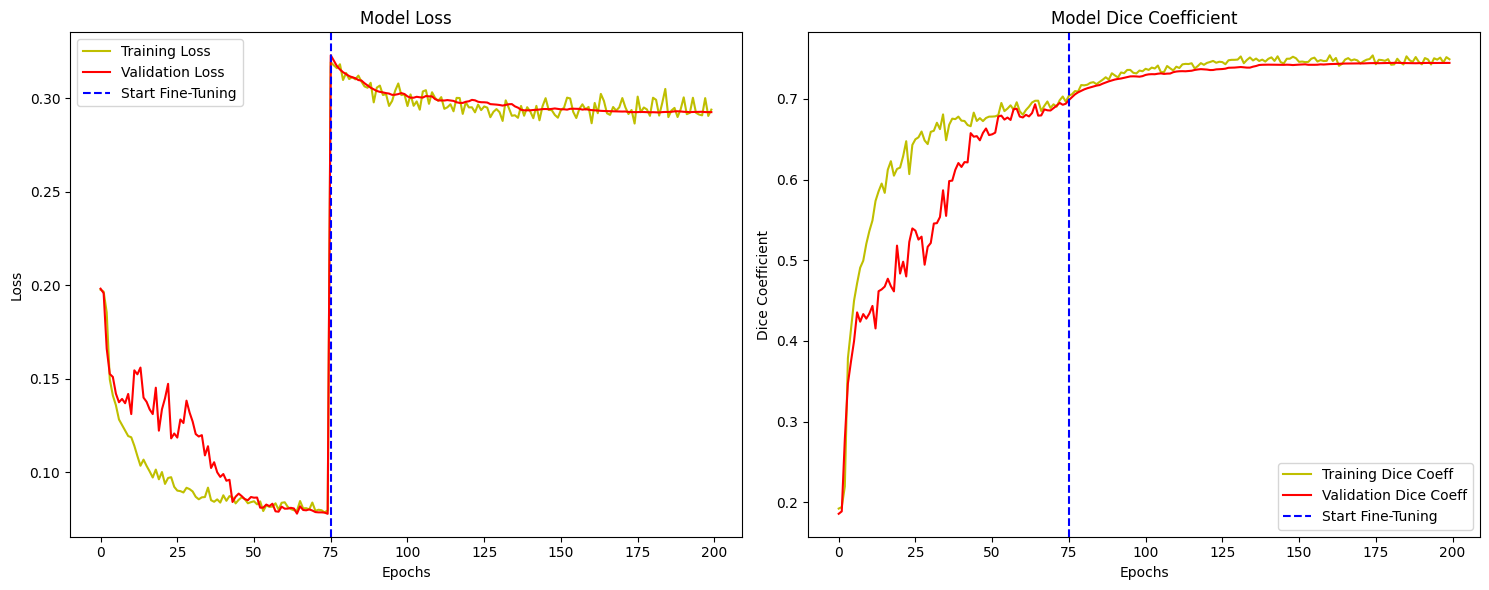

In [ ]:
# --- Visualize Full Training Progress ---

# Combine histories from both stages
full_history = {}
for key in history_stage1.history.keys():
    full_history[key] = history_stage1.history[key] + history_stage2.history[key]

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(full_history['loss'], 'y', label='Training Loss')
plt.plot(full_history['val_loss'], 'r', label='Validation Loss')
plt.axvline(x=len(history_stage1.history['loss']), color='b', linestyle='--', label='Start Fine-Tuning')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(full_history['dice_coef'], 'y', label='Training Dice Coeff')
plt.plot(full_history['val_dice_coef'], 'r', label='Validation Dice Coeff')
plt.axvline(x=len(history_stage1.history['loss']), color='b', linestyle='--', label='Start Fine-Tuning')
plt.title('Model Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()

plt.tight_layout()
plt.show()

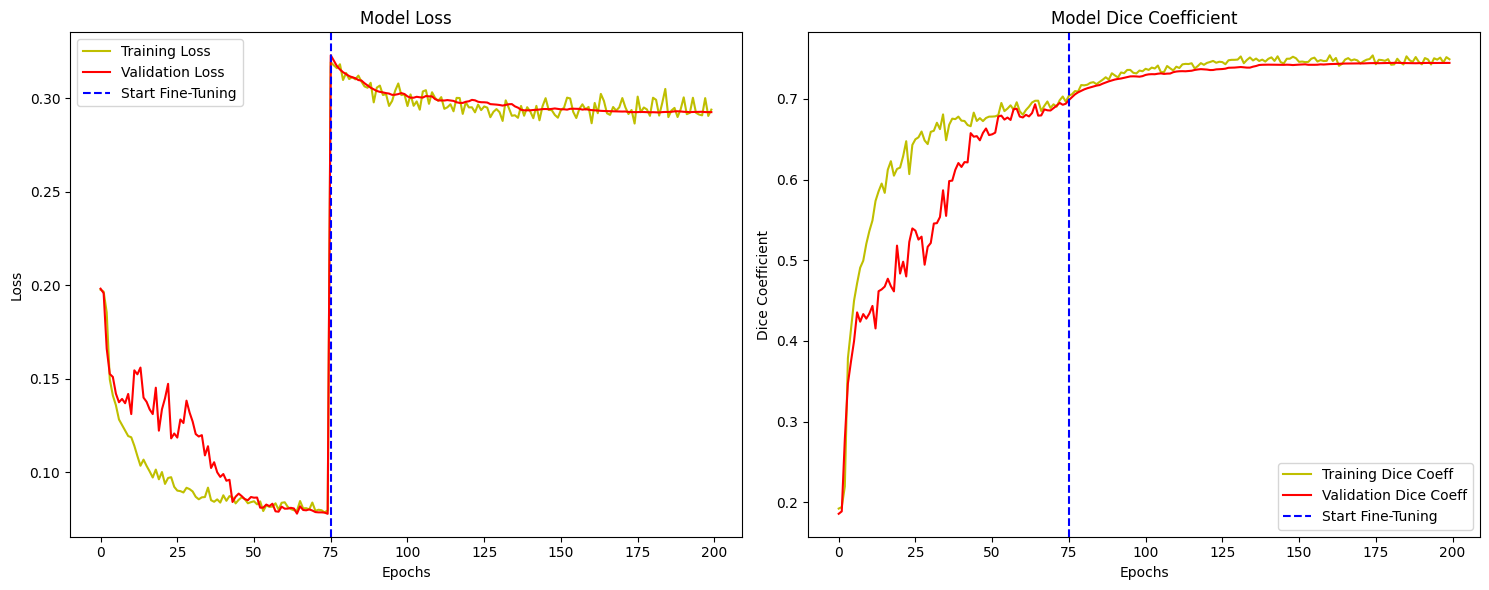

In [ ]:
# --- Visualize Full Training Progress ---

# Combine histories from both stages
full_history = {}
for key in history_stage1.history.keys():
    full_history[key] = history_stage1.history[key] + history_stage2.history[key]

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(full_history['loss'], 'y', label='Training Loss')
plt.plot(full_history['val_loss'], 'r', label='Validation Loss')
plt.axvline(x=len(history_stage1.history['loss']), color='b', linestyle='--', label='Start Fine-Tuning')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(full_history['dice_coef'], 'y', label='Training Dice Coeff')
plt.plot(full_history['val_dice_coef'], 'r', label='Validation Dice Coeff')
plt.axvline(x=len(history_stage1.history['loss']), color='b', linestyle='--', label='Start Fine-Tuning')
plt.title('Model Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()

plt.tight_layout()
plt.show()


--- Final Evaluation on Validation Set (using best model weights) ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - dice_coef: 0.7406 - loss: 0.2969

Final Validation Loss: 0.2925
Final Validation Dice Coefficient: 0.7447

--- Visualizing Sample Predictions ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


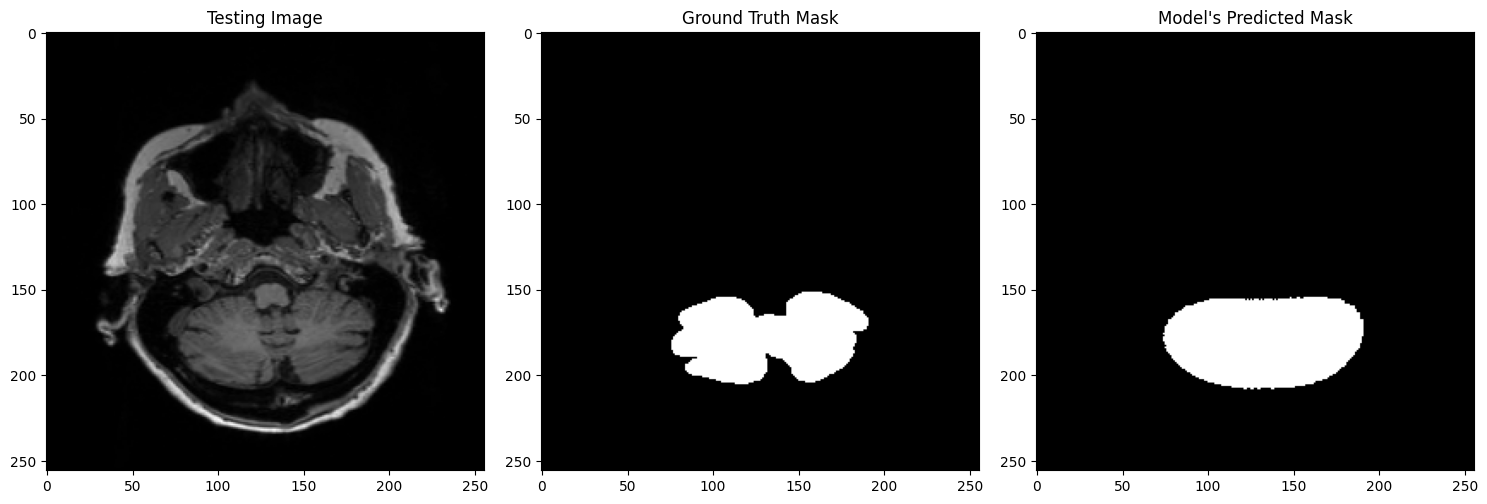

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


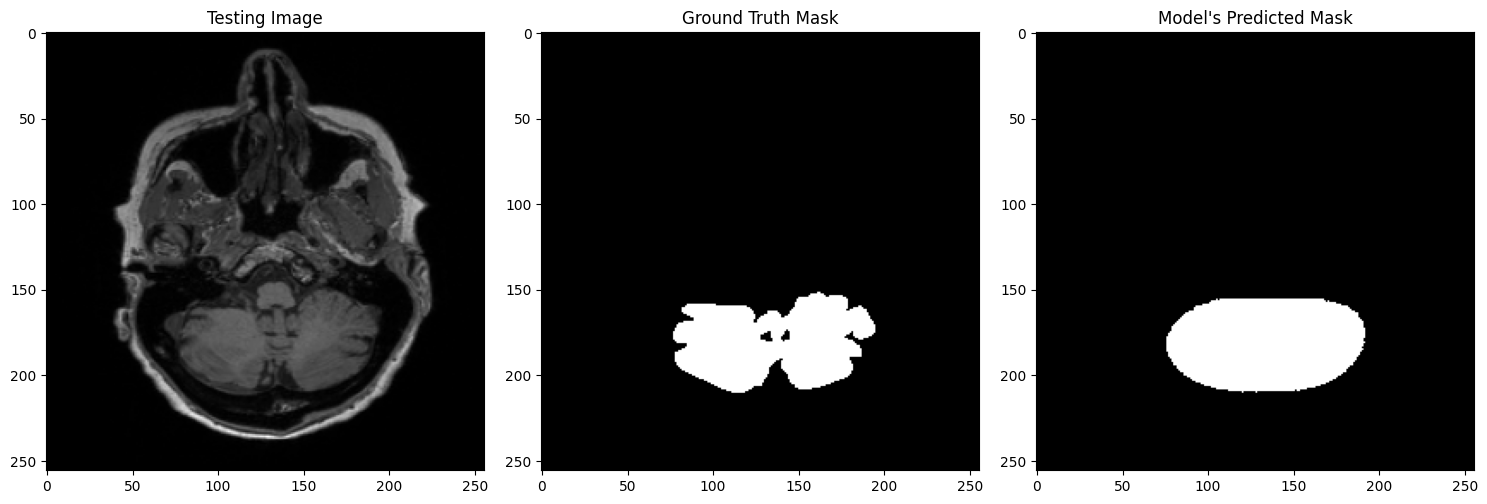

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


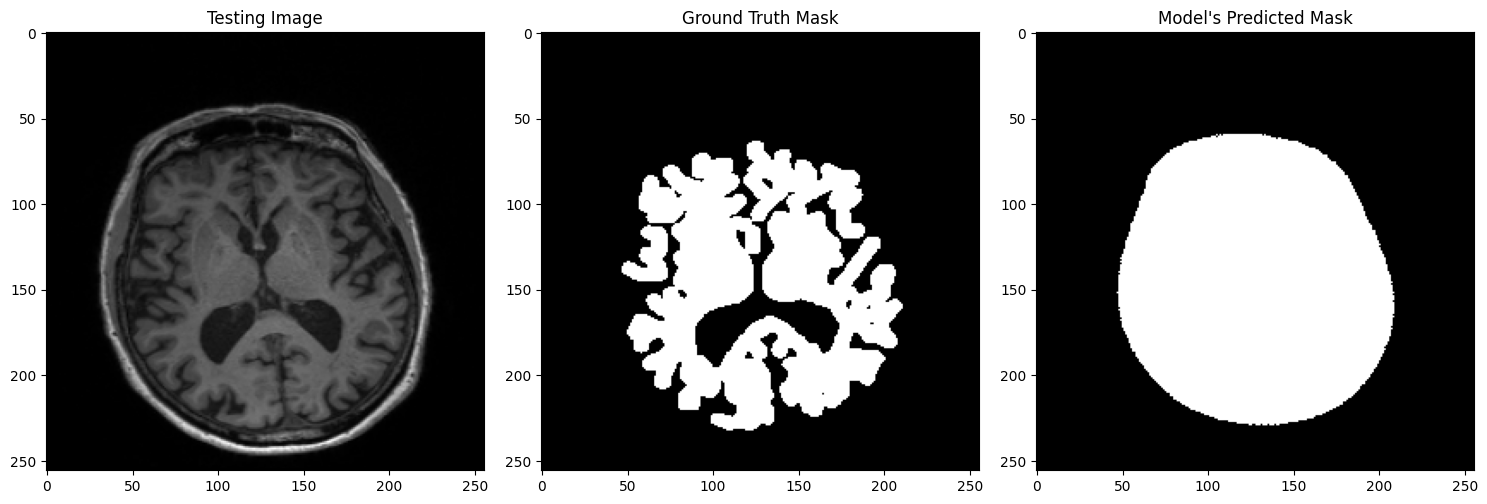

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


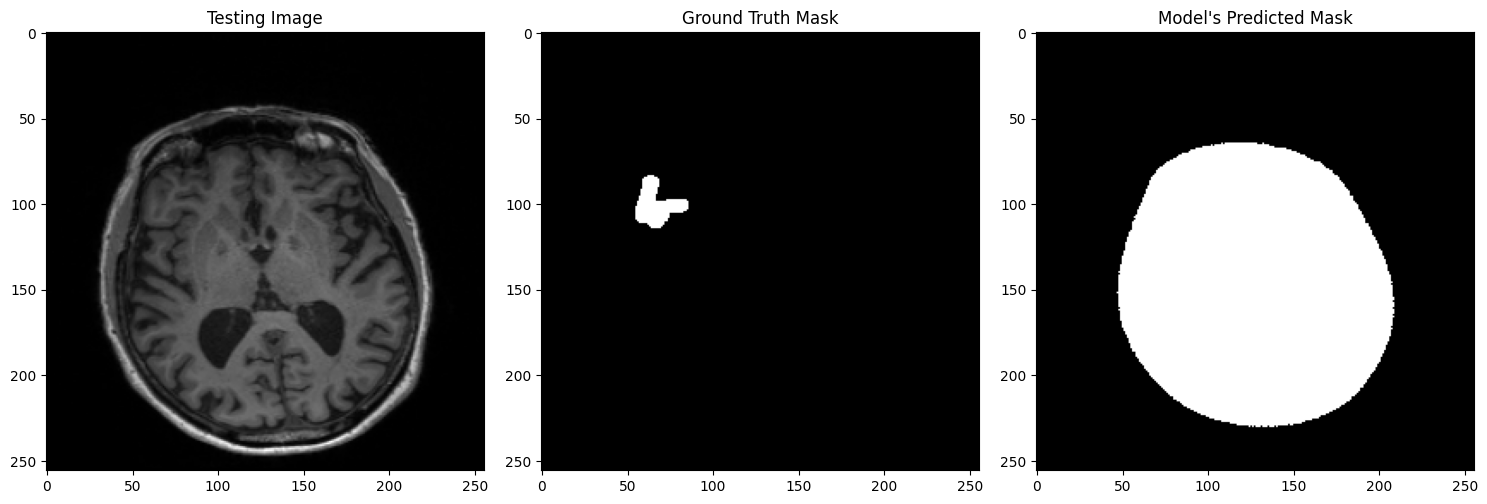

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


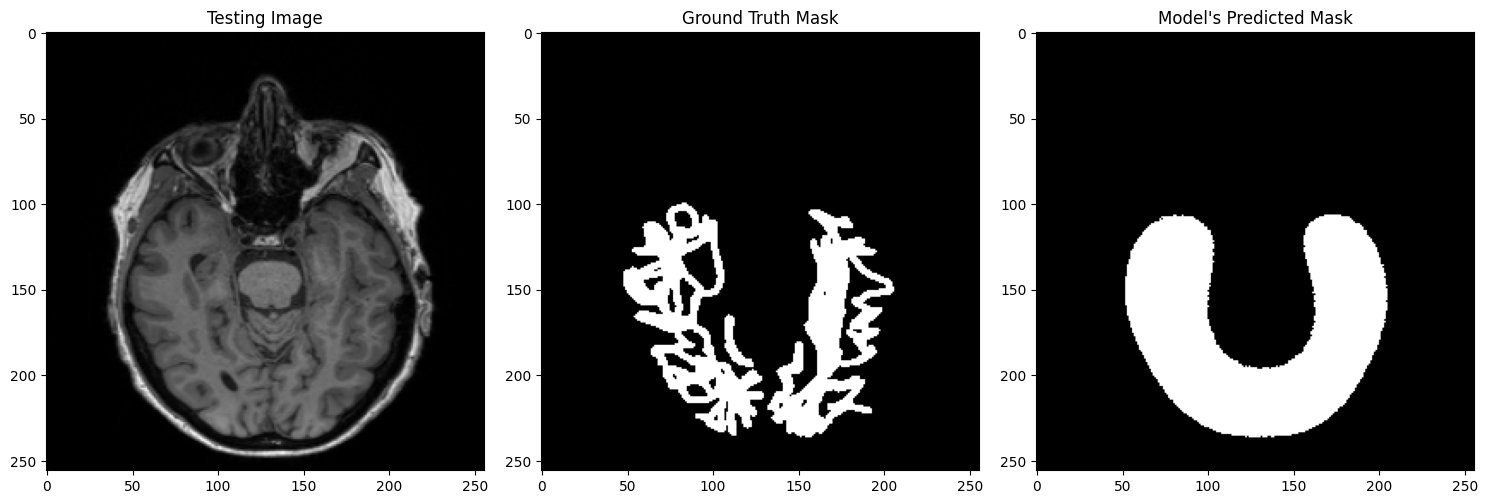

In [ ]:
# --- Final Evaluation and Visualization ---

# The model loaded by EarlyStopping is already the best one, so we can evaluate directly.
print("\n--- Final Evaluation on Validation Set (using best model weights) ---")
loss, dice = model.evaluate(val_generator)
print(f"\nFinal Validation Loss: {loss:.4f}")
print(f"Final Validation Dice Coefficient: {dice:.4f}")

# --- Visualize a few predictions ---
print("\n--- Visualizing Sample Predictions ---")
num_samples_to_show = 5
indices = np.random.choice(range(len(X_val)), num_samples_to_show, replace=False)

for i in indices:
    test_img = X_val[i]
    ground_truth = y_val[i]

    test_img_input_rgb = np.repeat(np.expand_dims(test_img, 0), 3, axis=-1)

    prediction = model.predict(test_img_input_rgb)[0]
    predicted_mask = (prediction > 0.5).astype(np.uint8)

    plt.figure(figsize=(15, 5))
    plt.subplot(131); plt.title('Testing Image'); plt.imshow(test_img[:, :, 0], cmap='gray')
    plt.subplot(132); plt.title('Ground Truth Mask'); plt.imshow(ground_truth[:, :, 0], cmap='gray')
    plt.subplot(133); plt.title('Model\'s Predicted Mask'); plt.imshow(predicted_mask[:, :, 0], cmap='gray')
    plt.tight_layout()
    plt.show()